<a href="https://colab.research.google.com/github/andy258741/NCHU_Finance/blob/main/7112029030_w10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 先載入必要套件
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [17]:
from datasets import load_dataset

# 載入 Financial Phrasebank 資料集，指定 config 名稱
dataset = load_dataset("takala/financial_phrasebank", name="sentences_allagree", split="train", trust_remote_code=True) # 選擇 'sentences_allagree' config
print(dataset)

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2264
})


In [20]:
from transformers import BertTokenizer

# 載入 BERT 預訓練模型的分詞器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 將文本和標籤進行分詞與編碼
def preprocess_data(examples):
    encoded = tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)
    return encoded

# 應用預處理
encoded_dataset = dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

In [21]:
from torch.utils.data import DataLoader
import torch

# 分割訓練集與測試集
train_test_split = encoded_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# 建立數據加載器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [22]:
# 查看一下分布
from collections import Counter
import pandas as pd

# 計算 train_dataset 中的標籤分佈
train_labels = [example['label'] for example in train_dataset]
train_label_counts = Counter(train_labels)

# 計算 test_dataset 中的標籤分佈
test_labels = [example['label'] for example in test_dataset]
test_label_counts = Counter(test_labels)

# 將結果轉為 DataFrame 方便查看比例
train_df = pd.DataFrame.from_dict(train_label_counts, orient='index', columns=['count'])
train_df['percentage'] = train_df['count'] / train_df['count'].sum() * 100

test_df = pd.DataFrame.from_dict(test_label_counts, orient='index', columns=['count'])
test_df['percentage'] = test_df['count'] / test_df['count'].sum() * 100

# 打印結果
print("Train Dataset Label Distribution:")
print(train_df)

print("\nTest Dataset Label Distribution:")
print(test_df)


Train Dataset Label Distribution:
   count  percentage
1   1111   61.347322
0    230   12.700166
2    470   25.952512

Test Dataset Label Distribution:
   count  percentage
1    280   61.810155
2    100   22.075055
0     73   16.114790
Dataset Label Distribution:
   count  percentage
1   1391   61.439929
2    570   25.176678
0    303   13.383392


In [23]:
from transformers import BertForSequenceClassification

# 載入 BERT 模型，分類頭數設定為3 (negative, neutral, positive)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# 先禁用wandb追蹤，用不到
import os
os.environ["WANDB_DISABLED"] = "true"

In [25]:
from transformers import Trainer, TrainingArguments

# 訓練參數
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
)

# 初始化Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
# 確認有使用GPU運算
print(f"模型是否在 GPU 上：{next(model.parameters()).is_cuda}")
# 開始訓練
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-25-7fcf481efa07>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


模型是否在 GPU 上：True


Epoch,Training Loss,Validation Loss
1,0.232100,0.192004
2,0.080100,0.139885
3,0.046300,0.156536


TrainOutput(global_step=342, training_loss=0.21016795801445406, metrics={'train_runtime': 139.8192, 'train_samples_per_second': 38.857, 'train_steps_per_second': 2.446, 'total_flos': 357373799629056.0, 'train_loss': 0.21016795801445406, 'epoch': 3.0})

In [26]:
# 使用測試集進行評估
results = trainer.evaluate()
print(results)

{'eval_loss': 0.1565363109111786, 'eval_runtime': 3.2114, 'eval_samples_per_second': 141.062, 'eval_steps_per_second': 17.749, 'epoch': 3.0}


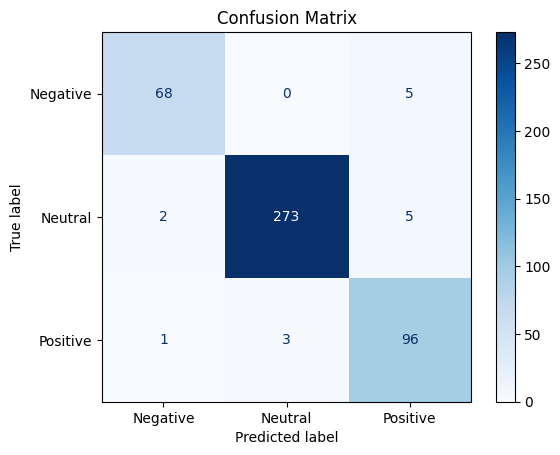

              precision    recall  f1-score   support

    Negative       0.96      0.93      0.94        73
     Neutral       0.99      0.97      0.98       280
    Positive       0.91      0.96      0.93       100

    accuracy                           0.96       453
   macro avg       0.95      0.96      0.95       453
weighted avg       0.97      0.96      0.96       453



In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 預測結果
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 分類指標
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))


In [31]:
# 從測試資料集隨機抽取三筆資料看看
import random
import pandas as pd
import numpy as np

# 獲取模型的預測結果
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# 將測試資料集轉為 DataFrame 方便操作
test_data = test_dataset.to_pandas()
test_data['true_label'] = y_true
test_data['predicted_label'] = y_pred
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
test_data['true_label_text'] = test_data['true_label'].map(label_map)
test_data['predicted_label_text'] = test_data['predicted_label'].map(label_map)

# 隨機抽取三筆資料
sampled_data = test_data.sample(n=3, random_state=42)

# 顯示抽樣結果
for index, row in sampled_data.iterrows():
    print(f"Sentence: {row['sentence']}")
    print(f"True Label: {row['true_label_text']}")
    print(f"Predicted Label: {row['predicted_label_text']}")
    print("-" * 50)


Sentence: First quarter underlying operating profit rose to 41 mln eur from 33 mln a year earlier .
True Label: Positive
Predicted Label: Positive
--------------------------------------------------
Sentence: Cash flow from operations totalled EUR 2.71 mn , compared to a negative EUR 0.83 mn in the corresponding period in 2008 .
True Label: Positive
Predicted Label: Positive
--------------------------------------------------
Sentence: The company reiterates its outlook for 2009 .
True Label: Neutral
Predicted Label: Neutral
--------------------------------------------------
